In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras_preprocessing.image import ImageDataGenerator


from src.ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCnn_Feit-reduced-rgb-no-inception-focal_loss"


/home/jelinek/recetox/src/notebooks/MyCNN


In [3]:
from keras.losses import CategoricalCrossentropy
from focal_loss import SparseCategoricalFocalLoss


class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256

    def execute_pipeline(self, perform_validation=True, save_model=True, perform_test_segmentation=True):
        data_train = self.get_data_loader_training()
        data_valid = self.get_data_loader_validation()

        self.model.compile(loss=SparseCategoricalFocalLoss(gamma=2),
                           optimizer='adam',
                           metrics=['accuracy'])

        self.model.summary()

        self._train_model(data_train, data_valid)

        if save_model:
            self.model.save('saved-models/' + self.params.name + '.h5')

        if perform_validation:
            eval_model(self.model,
                       data_valid,
                       self.params.name,
                       print_confusion_matrix=True,
                       save_misclassified=True)

        if perform_test_segmentation:
            self.perform_segmentation()

    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='same')(inputs)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=256, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=512, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=11, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='sparse', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='sparse', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)


        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=150,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [11]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

Model: "MySimpleCnnFewerLayers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64,

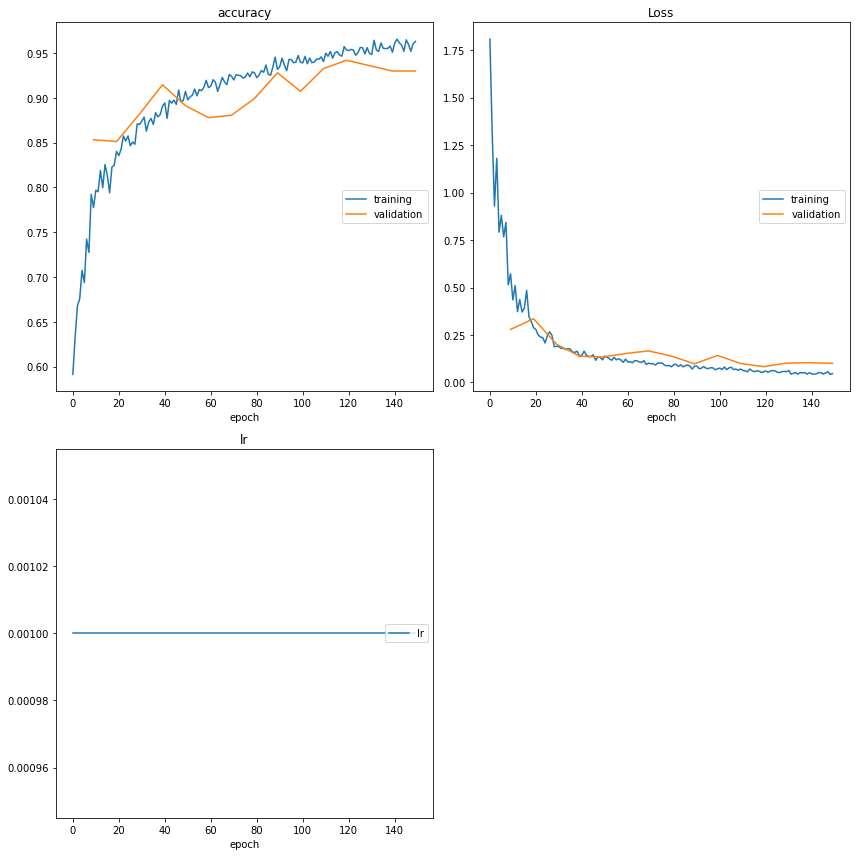

accuracy
	training         	 (min:    0.591, max:    0.965, cur:    0.963)
	validation       	 (min:    0.851, max:    0.942, cur:    0.930)
Loss
	training         	 (min:    0.042, max:    1.808, cur:    0.047)
	validation       	 (min:    0.083, max:    0.335, cur:    0.101)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
250/250 [==============================] - 23s 91ms/step - loss: 0.0466 - accuracy: 0.9630 - val_loss: 0.1010 - val_accuracy: 0.9300 - lr: 0.0010
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.7521ms
Confusion Matrix
[[326   1   1   0   3   0   0   0   0   0   4]
 [  0  35  20   1   2   0   3   3   0   0   0]
 [  1   1 138   0   2   0   0   3   0   0   0]
 [  0   0   0  10   1   0   0   0   0   0   0]
 [  0   1   4   1 538   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   0  17   0   0   0  53   7   0   0   0]
 [  0   0   3   0   0   0   1  82   0   0   0]
 [  0   0   0   0   0   0   1   0   0 

In [12]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [13]:
pipeline.save_pipeline()

In [14]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           name,
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1499 images belonging to 11 classes.
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.6967ms
Confusion Matrix
[[326   1   1   0   3   0   0   0   0   0   4]
 [  0  35  20   1   2   0   3   3   0   0   0]
 [  1   1 138   0   2   0   0   3   0   0   0]
 [  0   0   0  10   1   0   0   0   0   0   0]
 [  0   1   4   1 538   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   0  17   0   0   0  53   7   0   0   0]
 [  0   0   3   0   0   0   1  82   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0]
 [ 22   0   0   0   1   0   0   0   0   0 211]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.93      0.97      0.95       335
          blood_and_vessels       0.92      0.55      0.69        64
          connective_tissue       0.75      0.95      0.84       145
                      empty       0.83      0.9

In [4]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [5]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)

Processing region 120 out of 120
Post-processing image...
Processing grid point 663499 out of 663499
Processing image took 2340.5409457683563 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 1599360 out of 1599360
Processing image took 5430.261475801468 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 1544036 out of 1544036
Processing image took 5248.758283853531 seconds
Processing region 567 out of 567
Post-processing image...
Processing grid point 3520448 out of 3520448
Processing image took 12045.758958816528 seconds
Aggregated evaluation: 
[[446565   1979   7326    169   1761      0     13   1624      0      0
   69674]
 [     0      0      0      0      0      0      0      0      0      0
       0]
 [  1139   4675  21669   4542   3182      0   3361   7365      0      0
    6633]
 [   158    834      0   1299    737      0      0      6      0      0
    9491]
 [  1310   3547   4676  54876 176376      0 